In [1]:
import pandas as pd
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
import gc

# A. DATA NAN ANALYSIS

## 5min_liquidations

In [3]:
df2 = pd.read_csv("../sample_data/btc_5min_liquidations.csv", parse_dates=["BAR_TIMESTAMP"]).sort_values("BAR_TIMESTAMP").reset_index(drop=True)

In [4]:
def data_check_structured(df):
    results = {}
    
    # Ensure BAR_TIMESTAMP is datetime
    # df['BAR_TIMESTAMP'] = pd.to_datetime(df['BAR_TIMESTAMP'], errors='coerce')
    # df = df.sort_values('BAR_TIMESTAMP').reset_index(drop=True)

    # --- 1. NaN Analysis DataFrame ---
    nan_data = []
    for col in df.columns:
        is_nan = df[col].isna()
        nan_count = is_nan.sum()
        nan_percent = 100 * nan_count / len(df)
        longest_nan = is_nan.groupby((~is_nan).cumsum()).sum().max() if is_nan.any() else 0
        
        nan_data.append({
            "column": col,
            "nan_count": nan_count,
            "nan_percent": round(nan_percent, 2),
            "longest_consecutive_nan": longest_nan
        })
    results['nan_analysis'] = pd.DataFrame(nan_data)

    # --- 2. Timestamp Consistency ---
    df["delta_minutes"] = df["BAR_TIMESTAMP"].diff().dt.total_seconds() / 60
    missing_intervals = df[df["delta_minutes"] != 5].copy()
    
    results['timestamp_summary'] = {
        "total_rows": len(df),
        "duplicate_timestamps": int(df['BAR_TIMESTAMP'].duplicated().sum()),
        "non_5min_count": len(missing_intervals),
        "non_5min_percent": round(100 * len(missing_intervals) / len(df), 2), 
        "non_5min_max":   missing_intervals["delta_minutes"].max()   ,
        "non_5min_min":   missing_intervals["delta_minutes"].min()   ,
        "non_5min_mean": missing_intervals["delta_minutes"].mean() ,
        "non_5min_std":   missing_intervals["delta_minutes"].std()    
    }
    # Store the actual gaps if they exist
    results['missing_intervals_df'] = missing_intervals[["BAR_TIMESTAMP", "delta_minutes"]]

    # --- 3. Numeric Column Statistics ---
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    if numeric_cols:
        stats = df[numeric_cols].agg(['min', 'max', 'mean', 'std']).T
        stats['range'] = stats['max'] - stats['min']
        results['numeric_stats'] = stats.round(4)
    else:
        results['numeric_stats'] = pd.DataFrame()

    return results

# Example Usage:
# report = data_check_structured(my_df)
# print(report['nan_analysis'])
# print(report['numeric_stats'])

In [5]:
out = data_check_structured(df2)
out['timestamp_summary']

{'total_rows': 153909,
 'duplicate_timestamps': 0,
 'non_5min_count': 49788,
 'non_5min_percent': 32.35,
 'non_5min_max': np.float64(385.0),
 'non_5min_min': np.float64(10.0),
 'non_5min_mean': np.float64(18.58205957378432),
 'non_5min_std': np.float64(15.929549972266988)}

In [6]:
out['missing_intervals_df'].head(10)

,BAR_TIMESTAMP,delta_minutes
0,2023-01-01 00:05:00,NaN
1,2023-01-01 00:15:00,10.0
2,2023-01-01 00:30:00,15.0
3,2023-01-01 01:55:00,85.0
4,2023-01-01 03:15:00,80.0
5,2023-01-01 04:15:00,60.0
6,2023-01-01 04:45:00,30.0
7,2023-01-01 04:55:00,10.0
8,2023-01-01 07:15:00,140.0
9,2023-01-01 12:10:00,295.0


In [9]:
out['nan_analysis']

,column,nan_count,nan_percent,longest_consecutive_nan
0,EXCHANGE,0,0.00,0
1,SYMBOL,0,0.00,0
2,BAR_TIMESTAMP,0,0.00,0
3,BUY_LIQUIDATION_VOLUME,0,0.00,0
4,SELL_LIQUIDATION_VOLUME,0,0.00,0
5,TOTAL_LIQUIDATION_VOLUME,0,0.00,0
6,BUY_LIQUIDATION_COUNT,0,0.00,0
7,SELL_LIQUIDATION_COUNT,0,0.00,0
8,TOTAL_LIQUIDATION_COUNT,0,0.00,0
9,BUY_LIQUIDATION_NOTIONAL,0,0.00,0


In [10]:
out['numeric_stats']

,min,max,mean,std,range
BUY_LIQUIDATION_VOLUME,0.000,8.057010e+02,0.3161,2.4508,8.057010e+02
SELL_LIQUIDATION_VOLUME,0.000,1.907530e+03,0.3133,5.1527,1.907530e+03
TOTAL_LIQUIDATION_VOLUME,0.001,1.907530e+03,0.6295,5.7037,1.907529e+03
BUY_LIQUIDATION_COUNT,0.000,1.290000e+02,4.0715,7.6239,1.290000e+02
SELL_LIQUIDATION_COUNT,0.000,2.180000e+02,3.8804,8.3297,2.180000e+02
TOTAL_LIQUIDATION_COUNT,1.000,2.310000e+02,7.9519,10.6325,2.300000e+02
BUY_LIQUIDATION_NOTIONAL,0.000,1.000697e+08,19456.1317,275803.3503,1.000697e+08
SELL_LIQUIDATION_NOTIONAL,0.000,1.990447e+08,19613.7310,533059.2070,1.990447e+08
TOTAL_LIQUIDATION_NOTIONAL,3.526,1.990447e+08,39069.8627,600139.0987,1.990446e+08
AVG_BUY_LIQUIDATION_SIZE,0.001,2.701200e+01,0.0630,0.1990,2.701100e+01


In [95]:

def plot_data(df, nan_temporal_plot_only= False) : 
    df['BAR_TIMESTAMP'] = pd.to_datetime(df['BAR_TIMESTAMP'], errors='coerce')
    df = df.sort_values("BAR_TIMESTAMP").reset_index(drop=True)


    # --- 3. NaNs per row over time (smoothed) ---
    nan_counts = df.isna().sum(axis=1)
    rolling_window = 50  # smooth over 50 rows
    nan_counts_smoothed = nan_counts.rolling(rolling_window).mean()
    plt.figure(figsize=(15,4))
    plt.plot(df["BAR_TIMESTAMP"], nan_counts_smoothed)
    plt.title(f"Smoothed NaNs per row over time (rolling window={rolling_window})")
    plt.xlabel("Timestamp")
    plt.ylabel("NaNs (smoothed)")
    plt.show() 
    if nan_temporal_plot_only : 
        return



    # --- 1. NaN heatmap with row grouping ---
    group_size = 200
    grouped_nan = df.isna().groupby(np.arange(len(df)) // group_size).mean()

    plt.figure(figsize=(15,6))
    sns.heatmap(grouped_nan.T, cbar=True, cmap="Reds")
    plt.title(f"NaN Heatmap (smoothed by {group_size} rows)")
    plt.xlabel("Row group")
    plt.ylabel("Columns")
    plt.show()

    # --- 2. Timestamp gaps ---
    df["delta_minutes"] = df["BAR_TIMESTAMP"].diff().dt.total_seconds() / 60

    plt.figure(figsize=(15,4))
    plt.plot(df["BAR_TIMESTAMP"], df["delta_minutes"], marker='o', linestyle='None', markersize=2)
    plt.title("Time Gaps Between Consecutive Rows (minutes)")
    plt.xlabel("Timestamp")
    plt.ylabel("Delta (minutes)")
    plt.ylim(0, df["delta_minutes"].max()+5)
    plt.show()

    # --- 2a. Histogram + aggregated stats for delta_minutes ---
    plt.figure(figsize=(10,4))
    sns.histplot(df["delta_minutes"].dropna(), bins=50, kde=True)
    plt.title("Histogram of delta_minutes (consecutive time gaps)")
    plt.xlabel("Delta minutes")
    plt.ylabel("Frequency")
    plt.show()

    # Aggregated stats
    delta_stats = df["delta_minutes"].describe()
    print("=== delta_minutes Statistics ===")
    print(delta_stats)

    # Optional: count of rows with delta != 5
    non_5min = (df["delta_minutes"] != 5).sum()
    print(f"Number of rows with delta != 5 minutes: {non_5min}")







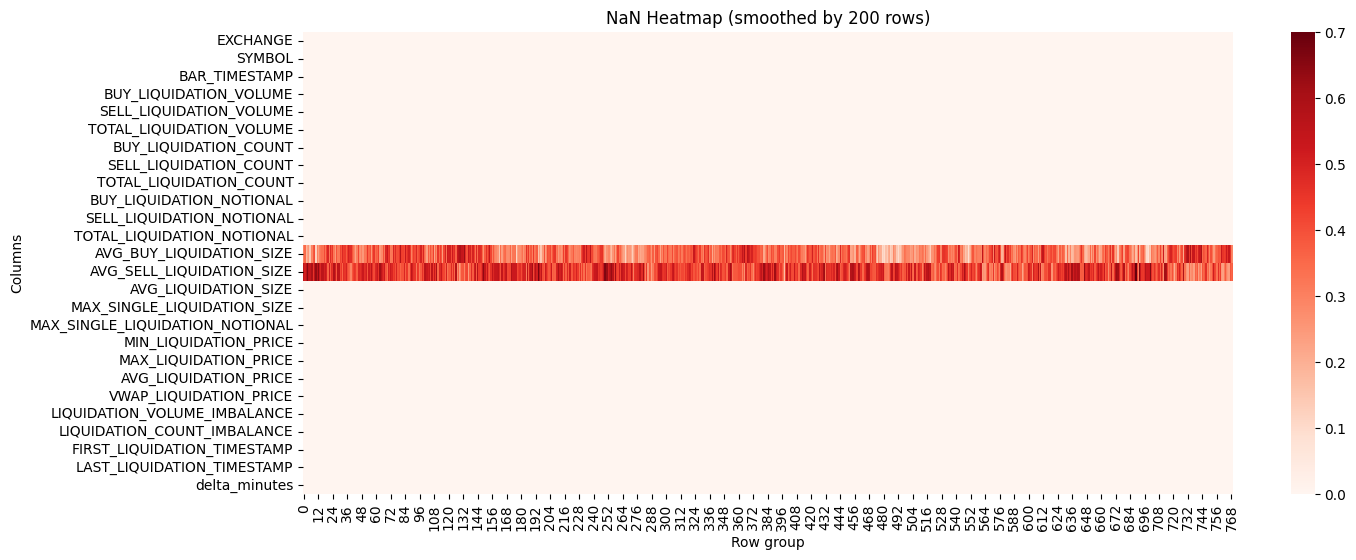

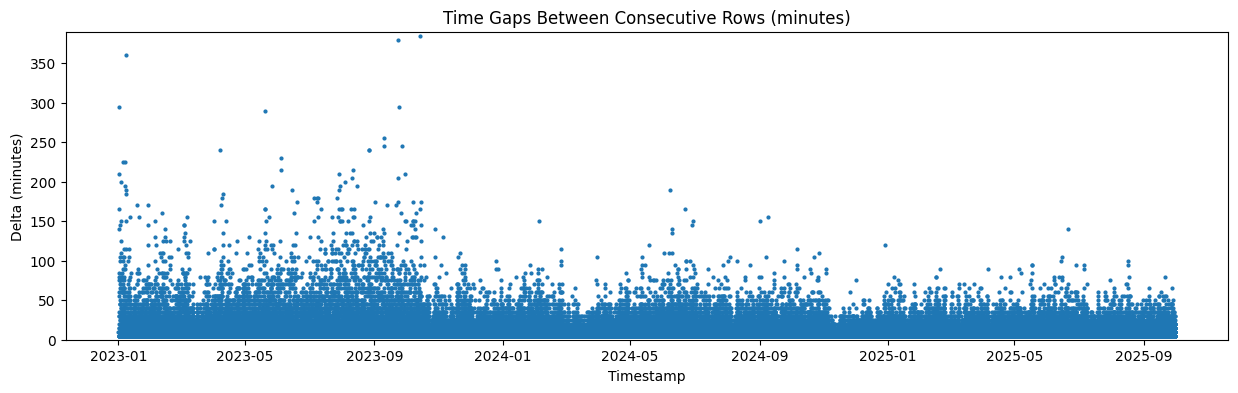

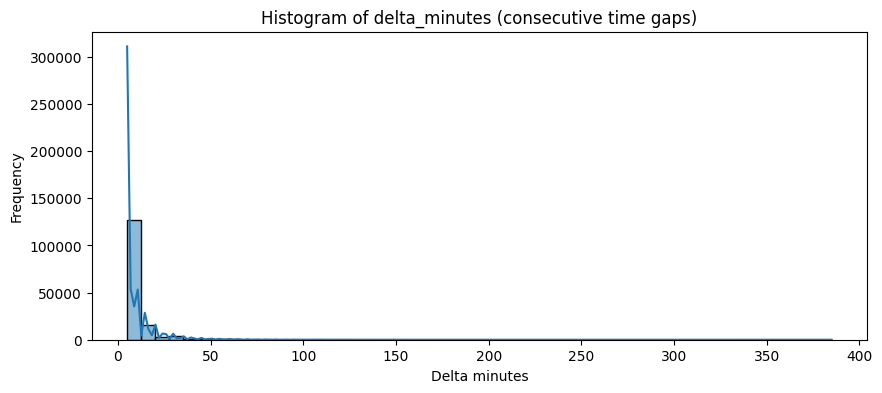

=== delta_minutes Statistics ===
count    153908.000000
mean          9.393599
std          11.065901
min           5.000000
25%           5.000000
50%           5.000000
75%          10.000000
max         385.000000
Name: delta_minutes, dtype: float64
Number of rows with delta != 5 minutes: 49788


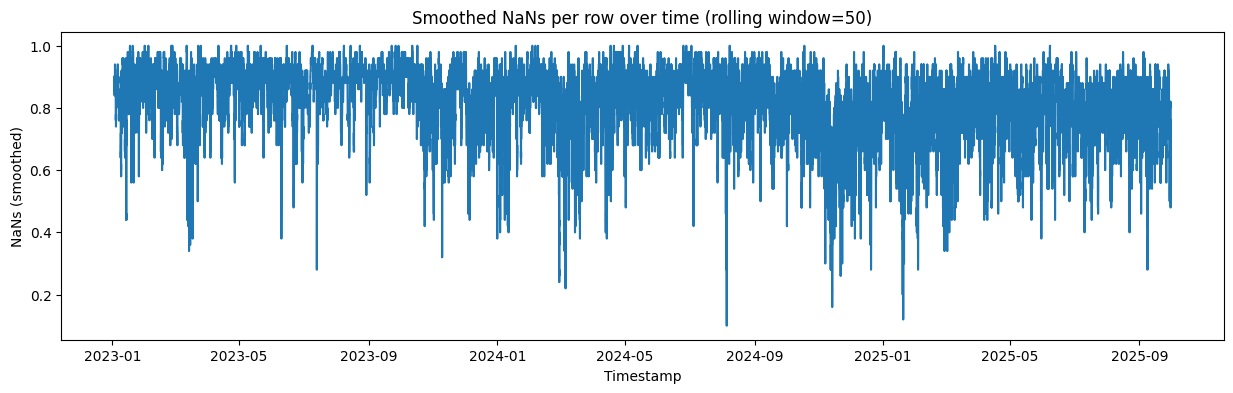

In [12]:
plot_data(df2)

In [27]:
import gc
del df2
gc.collect()

16157

In [46]:
df2.columns.tolist()

['EXCHANGE',
 'SYMBOL',
 'BAR_TIMESTAMP',
 'BUY_LIQUIDATION_VOLUME',
 'SELL_LIQUIDATION_VOLUME',
 'TOTAL_LIQUIDATION_VOLUME',
 'BUY_LIQUIDATION_COUNT',
 'SELL_LIQUIDATION_COUNT',
 'TOTAL_LIQUIDATION_COUNT',
 'BUY_LIQUIDATION_NOTIONAL',
 'SELL_LIQUIDATION_NOTIONAL',
 'TOTAL_LIQUIDATION_NOTIONAL',
 'AVG_BUY_LIQUIDATION_SIZE',
 'AVG_SELL_LIQUIDATION_SIZE',
 'AVG_LIQUIDATION_SIZE',
 'MAX_SINGLE_LIQUIDATION_SIZE',
 'MAX_SINGLE_LIQUIDATION_NOTIONAL',
 'MIN_LIQUIDATION_PRICE',
 'MAX_LIQUIDATION_PRICE',
 'AVG_LIQUIDATION_PRICE',
 'VWAP_LIQUIDATION_PRICE',
 'LIQUIDATION_VOLUME_IMBALANCE',
 'LIQUIDATION_COUNT_IMBALANCE',
 'FIRST_LIQUIDATION_TIMESTAMP',
 'LAST_LIQUIDATION_TIMESTAMP']

In [16]:
df2[['AVG_BUY_LIQUIDATION_SIZE', 'AVG_SELL_LIQUIDATION_SIZE', 'AVG_LIQUIDATION_SIZE']].head(10)

,AVG_BUY_LIQUIDATION_SIZE,AVG_SELL_LIQUIDATION_SIZE,AVG_LIQUIDATION_SIZE
0,NaN,0.001000,0.001000
1,NaN,0.007000,0.007000
2,NaN,0.004000,0.004000
3,0.7120,NaN,0.712000
4,NaN,0.111000,0.111000
5,NaN,0.019667,0.019667
6,NaN,0.047333,0.047333
7,NaN,0.050000,0.050000
8,NaN,0.444000,0.444000
9,0.0968,NaN,0.096800


In [17]:
#set all NaNs to 0s , NaNs only present by mistake in buy/sell avg liq size
df2.fillna(0, inplace=True)

In [18]:
df2.isna().sum()

EXCHANGE                           0
SYMBOL                             0
BAR_TIMESTAMP                      0
BUY_LIQUIDATION_VOLUME             0
SELL_LIQUIDATION_VOLUME            0
TOTAL_LIQUIDATION_VOLUME           0
BUY_LIQUIDATION_COUNT              0
SELL_LIQUIDATION_COUNT             0
TOTAL_LIQUIDATION_COUNT            0
BUY_LIQUIDATION_NOTIONAL           0
SELL_LIQUIDATION_NOTIONAL          0
TOTAL_LIQUIDATION_NOTIONAL         0
AVG_BUY_LIQUIDATION_SIZE           0
AVG_SELL_LIQUIDATION_SIZE          0
AVG_LIQUIDATION_SIZE               0
MAX_SINGLE_LIQUIDATION_SIZE        0
MAX_SINGLE_LIQUIDATION_NOTIONAL    0
MIN_LIQUIDATION_PRICE              0
MAX_LIQUIDATION_PRICE              0
AVG_LIQUIDATION_PRICE              0
VWAP_LIQUIDATION_PRICE             0
LIQUIDATION_VOLUME_IMBALANCE       0
LIQUIDATION_COUNT_IMBALANCE        0
FIRST_LIQUIDATION_TIMESTAMP        0
LAST_LIQUIDATION_TIMESTAMP         0
delta_minutes                      0
dtype: int64

## 5min_deriv

In [19]:
df = pd.read_csv("../sample_data/btc_5min_derivatives.csv", parse_dates=["BAR_TIMESTAMP"]).sort_values("BAR_TIMESTAMP").reset_index(drop=True)

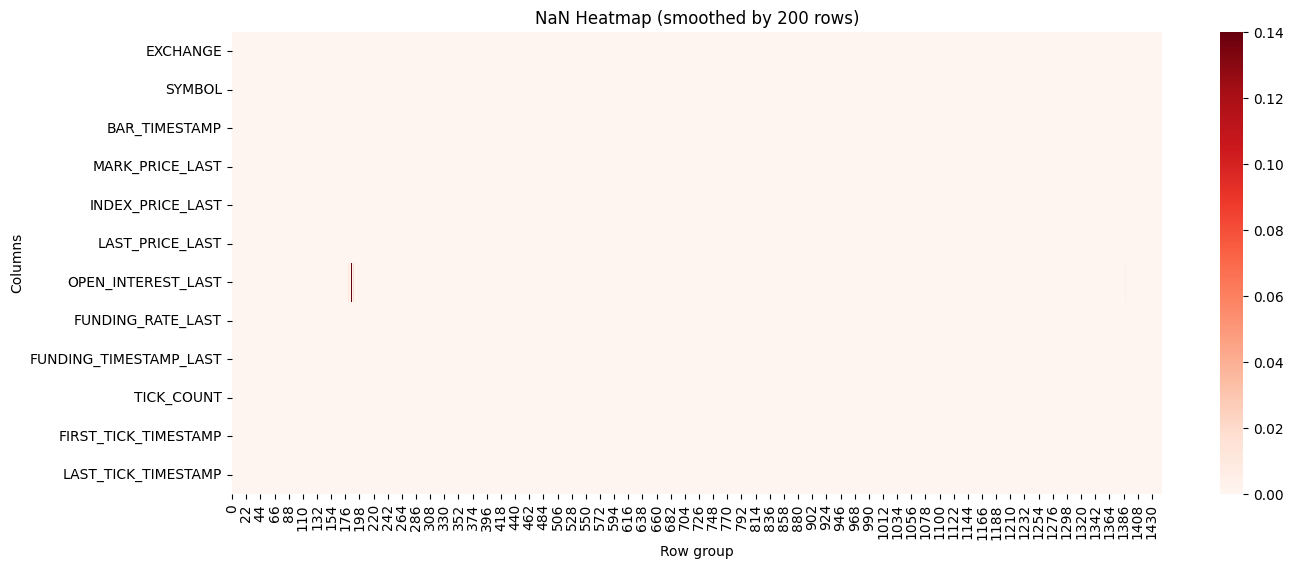

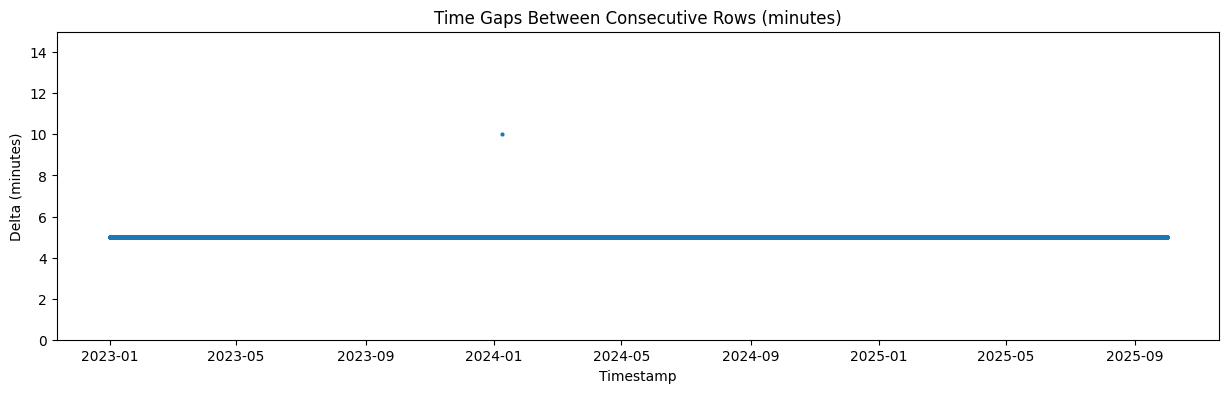

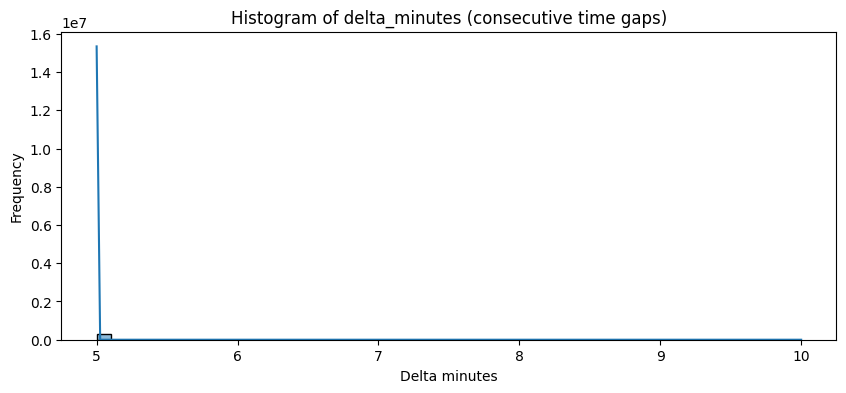

=== delta_minutes Statistics ===
count    289150.000000
mean          5.000017
std           0.009298
min           5.000000
25%           5.000000
50%           5.000000
75%           5.000000
max          10.000000
Name: delta_minutes, dtype: float64
Number of rows with delta != 5 minutes: 2


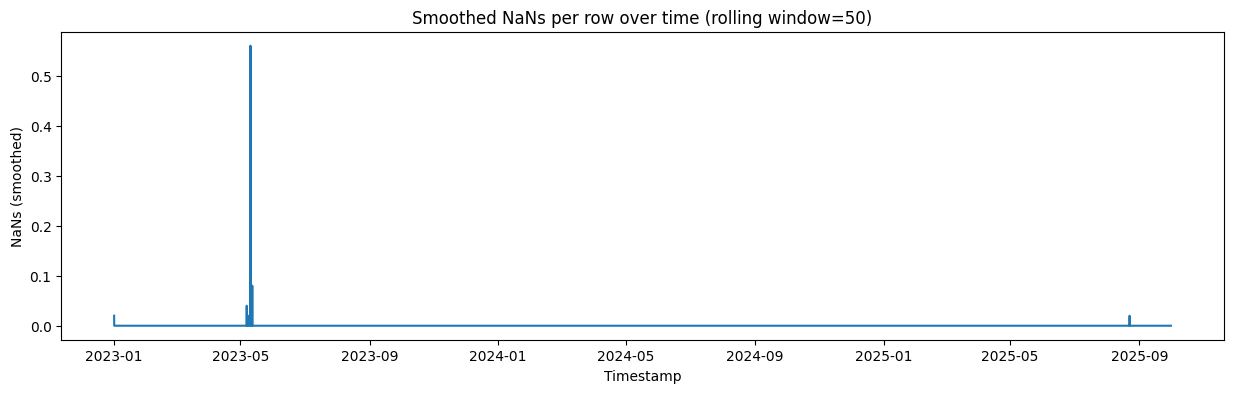

In [20]:
plot_data(df)

In [21]:
out= data_check_structured(df)
out['timestamp_summary']

{'total_rows': 289151,
 'duplicate_timestamps': 0,
 'non_5min_count': 2,
 'non_5min_percent': 0.0,
 'non_5min_max': np.float64(10.0),
 'non_5min_min': np.float64(10.0),
 'non_5min_mean': np.float64(10.0),
 'non_5min_std': np.float64(nan)}

In [22]:
out['missing_intervals_df'].head(10)

,BAR_TIMESTAMP,delta_minutes
0,2023-01-01 00:00:00,NaN
107361,2024-01-08 18:50:00,10.0


In [23]:
out['nan_analysis']

,column,nan_count,nan_percent,longest_consecutive_nan
0,EXCHANGE,0,0.00,0
1,SYMBOL,0,0.00,0
2,BAR_TIMESTAMP,0,0.00,0
3,MARK_PRICE_LAST,0,0.00,0
4,INDEX_PRICE_LAST,0,0.00,0
5,LAST_PRICE_LAST,0,0.00,0
6,OPEN_INTEREST_LAST,36,0.01,26
7,FUNDING_RATE_LAST,0,0.00,0
8,FUNDING_TIMESTAMP_LAST,0,0.00,0
9,TICK_COUNT,0,0.00,0


In [24]:
out['numeric_stats']

,min,max,mean,std,range
MARK_PRICE_LAST,16500.0000,124214.4933,62267.0892,31176.9608,107714.4933
INDEX_PRICE_LAST,16509.6239,124179.1052,62279.7265,31187.0501,107669.4813
LAST_PRICE_LAST,16499.8000,124249.9000,62265.9998,31176.3049,107750.1000
OPEN_INTEREST_LAST,5540.7540,128427.9980,87912.7439,11887.4897,122887.2440
FUNDING_RATE_LAST,-0.0002,0.0012,0.0001,0.0001,0.0014
TICK_COUNT,112.0000,976.0000,452.1312,91.7554,864.0000
delta_minutes,5.0000,10.0000,5.0000,0.0093,5.0000


In [ ]:
del df 
gc.collect()

## 5min_trades

In [25]:
df3 = pd.read_csv("../sample_data/btc_5min_trades.csv", parse_dates=["BAR_TIMESTAMP"]).sort_values("BAR_TIMESTAMP").reset_index(drop=True)
# plot_data(df3)

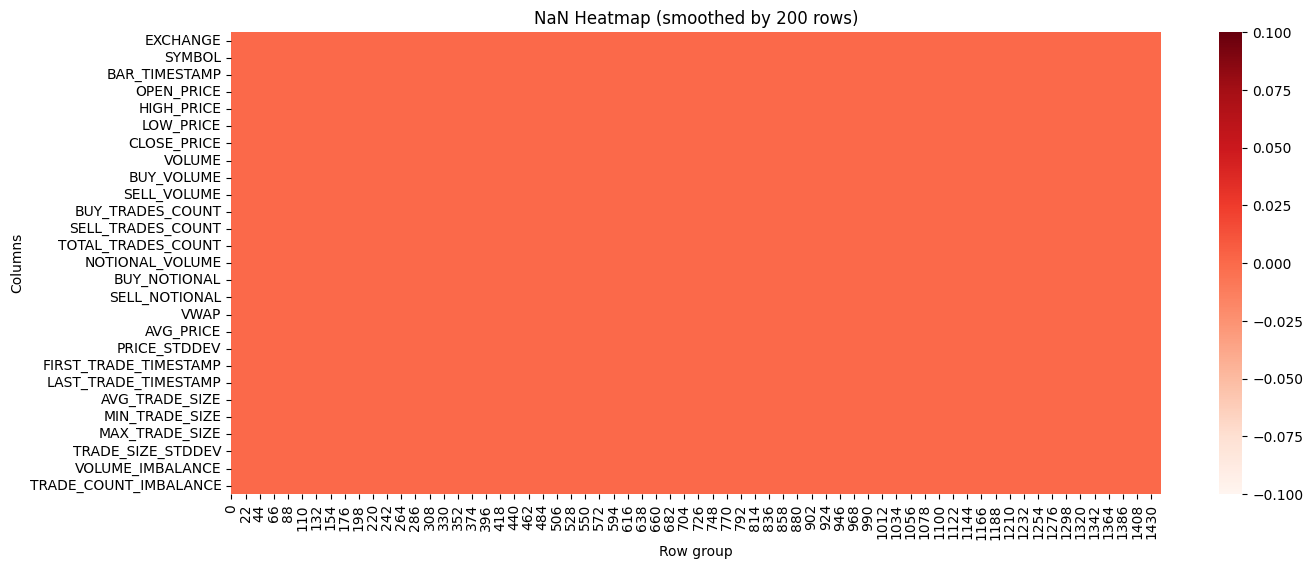

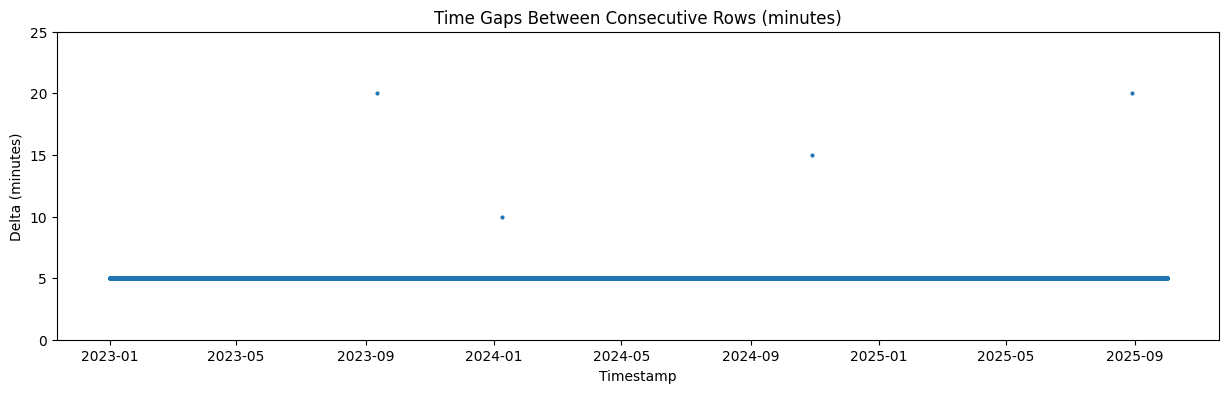

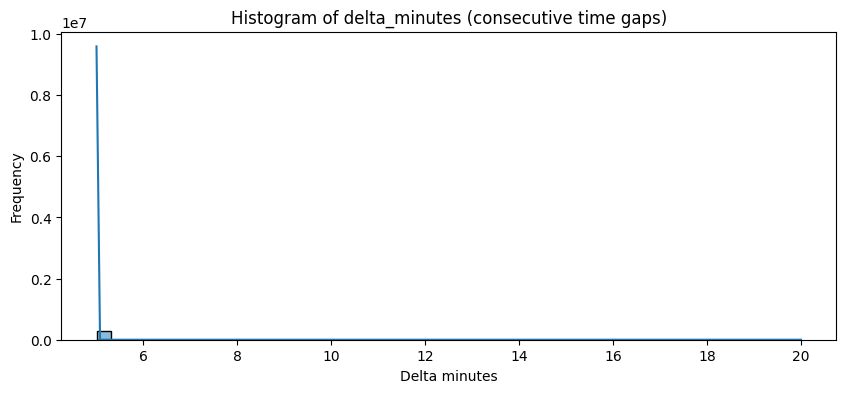

=== delta_minutes Statistics ===
count    289142.000000
mean          5.000156
std           0.044594
min           5.000000
25%           5.000000
50%           5.000000
75%           5.000000
max          20.000000
Name: delta_minutes, dtype: float64
Number of rows with delta != 5 minutes: 5


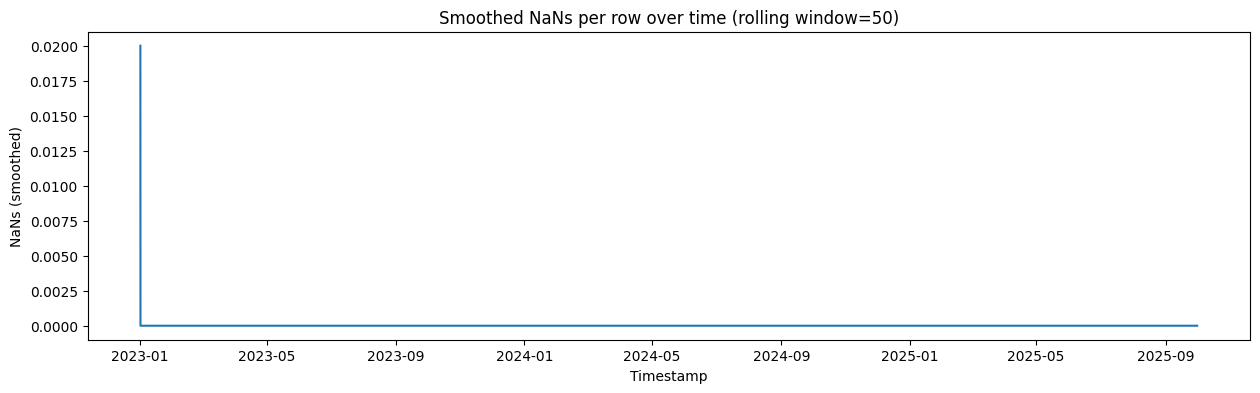

In [26]:
plot_data(df3)

In [18]:
del df3
gc.collect()

31424

In [27]:
out= data_check_structured(df3)
out['timestamp_summary']

{'total_rows': 289143,
 'duplicate_timestamps': 0,
 'non_5min_count': 5,
 'non_5min_percent': 0.0,
 'non_5min_max': np.float64(20.0),
 'non_5min_min': np.float64(10.0),
 'non_5min_mean': np.float64(16.25),
 'non_5min_std': np.float64(4.7871355387816905)}

In [28]:
out['missing_intervals_df'].head(10)

,BAR_TIMESTAMP,delta_minutes
0,2023-01-01 00:00:00,NaN
73255,2023-09-12 08:50:00,20.0
107358,2024-01-08 18:50:00,10.0
192001,2024-10-28 16:35:00,15.0
279718,2025-08-29 06:35:00,20.0


In [29]:
out['nan_analysis']

,column,nan_count,nan_percent,longest_consecutive_nan
0,EXCHANGE,0,0.0,0
1,SYMBOL,0,0.0,0
2,BAR_TIMESTAMP,0,0.0,0
3,OPEN_PRICE,0,0.0,0
4,HIGH_PRICE,0,0.0,0
5,LOW_PRICE,0,0.0,0
6,CLOSE_PRICE,0,0.0,0
7,VOLUME,0,0.0,0
8,BUY_VOLUME,0,0.0,0
9,SELL_VOLUME,0,0.0,0


In [30]:
out['numeric_stats']

,min,max,mean,std,range
OPEN_PRICE,16499.9000,1.243000e+05,6.226548e+04,3.117606e+04,1.078001e+05
HIGH_PRICE,16500.0000,1.245456e+05,6.232066e+04,3.120024e+04,1.080456e+05
LOW_PRICE,16488.0000,1.241505e+05,6.220944e+04,3.115156e+04,1.076625e+05
CLOSE_PRICE,16499.9000,1.243000e+05,6.226582e+04,3.117610e+04,1.078001e+05
VOLUME,9.0480,8.678249e+04,1.029693e+03,1.833480e+03,8.677344e+04
BUY_VOLUME,2.3080,5.297638e+04,5.123533e+02,9.327606e+02,5.297407e+04
SELL_VOLUME,2.8030,5.114230e+04,5.173396e+02,9.395938e+02,5.113949e+04
BUY_TRADES_COUNT,116.0000,2.825140e+05,6.032199e+03,7.388914e+03,2.823980e+05
SELL_TRADES_COUNT,101.0000,2.432520e+05,6.074410e+03,7.428699e+03,2.431510e+05
TOTAL_TRADES_COUNT,385.0000,4.741980e+05,1.210661e+04,1.457481e+04,4.738130e+05


## summary
1. 5min_liq has non 5min differences which have to be fixed.  No NaNs in existing (some logical err in avg_buy/sell_liq_size corrected in code above to fix NaNs)
2. 5min_deriv has no NaN values, 1 timestamp of non 5min diff ~ negligible 
3. 5min_trades has no NaN values, 4 timestamps of non 5min diff ~ negligible

# B. FINAL MERGE DATA

In [31]:
from functools import reduce

# Example: array of DataFrames
dfs = [df, df2, df3]  # your list of DataFrames

# Merge all DataFrames on BAR_TIMESTAMP using outer join
df_merged = reduce(lambda left, right: pd.merge(left, right, on="BAR_TIMESTAMP", how="outer"), dfs)

# Sort by timestamp
df_merged = df_merged.sort_values("BAR_TIMESTAMP").reset_index(drop=True)



In [32]:
df_merged.head(5)

,EXCHANGE_x,SYMBOL_x,BAR_TIMESTAMP,MARK_PRICE_LAST,INDEX_PRICE_LAST,LAST_PRICE_LAST,OPEN_INTEREST_LAST,FUNDING_RATE_LAST,FUNDING_TIMESTAMP_LAST,TICK_COUNT,...,PRICE_STDDEV,FIRST_TRADE_TIMESTAMP,LAST_TRADE_TIMESTAMP,AVG_TRADE_SIZE,MIN_TRADE_SIZE,MAX_TRADE_SIZE,TRADE_SIZE_STDDEV,VOLUME_IMBALANCE,TRADE_COUNT_IMBALANCE,delta_minutes
0,binance-futures,BTCUSDT,2023-01-01 00:00:00,16529.200000,16535.114333,16529.2,105581.777,0.0001,2023-01-01 08:00:00.000,531,...,4.658046,2023-01-01 00:00:04.118,2023-01-01 00:04:59.783,0.207688,0.001,12.656,0.551623,-238.467,-1223.0,NaN
1,binance-futures,BTCUSDT,2023-01-01 00:05:00,16521.500000,16527.421047,16521.5,105607.666,0.0001,2023-01-01 08:00:00.000,534,...,4.730635,2023-01-01 00:05:00.045,2023-01-01 00:09:59.917,0.130437,0.001,8.458,0.360166,-86.071,-653.0,5.0
2,binance-futures,BTCUSDT,2023-01-01 00:10:00,16517.400000,16522.583810,16517.4,105604.357,0.0001,2023-01-01 08:00:00.000,529,...,1.988034,2023-01-01 00:10:00.477,2023-01-01 00:14:59.947,0.138483,0.001,3.766,0.297205,19.624,-367.0,5.0
3,binance-futures,BTCUSDT,2023-01-01 00:15:00,16530.443023,16536.537968,16530.1,105641.237,0.0001,2023-01-01 08:00:00.000,518,...,6.020564,2023-01-01 00:15:00.135,2023-01-01 00:19:59.341,0.194185,0.001,5.000,0.412914,68.448,452.0,5.0
4,binance-futures,BTCUSDT,2023-01-01 00:20:00,16531.800000,16536.153333,16531.8,105733.505,0.0001,2023-01-01 08:00:00.000,512,...,2.118028,2023-01-01 00:20:00.250,2023-01-01 00:24:59.628,0.155921,0.001,5.057,0.348629,81.538,335.0,5.0


In [33]:
print(df_merged.isna().sum().to_string())

EXCHANGE_x                              0
SYMBOL_x                                0
BAR_TIMESTAMP                           0
MARK_PRICE_LAST                         0
INDEX_PRICE_LAST                        0
LAST_PRICE_LAST                         0
OPEN_INTEREST_LAST                     36
FUNDING_RATE_LAST                       0
FUNDING_TIMESTAMP_LAST                  0
TICK_COUNT                              0
FIRST_TICK_TIMESTAMP                    0
LAST_TICK_TIMESTAMP                     0
delta_minutes_x                         1
EXCHANGE_y                         135242
SYMBOL_y                           135242
BUY_LIQUIDATION_VOLUME             135242
SELL_LIQUIDATION_VOLUME            135242
TOTAL_LIQUIDATION_VOLUME           135242
BUY_LIQUIDATION_COUNT              135242
SELL_LIQUIDATION_COUNT             135242
TOTAL_LIQUIDATION_COUNT            135242
BUY_LIQUIDATION_NOTIONAL           135242
SELL_LIQUIDATION_NOTIONAL          135242
TOTAL_LIQUIDATION_NOTIONAL        

In [ ]:
# df_merged['BAR_TIMESTAMP'] = pd.to_datetime(df_merged['BAR_TIMESTAMP'], errors='coerce')
# df_merged = df_merged.sort_values('BAR_TIMESTAMP').reset_index(drop=True)

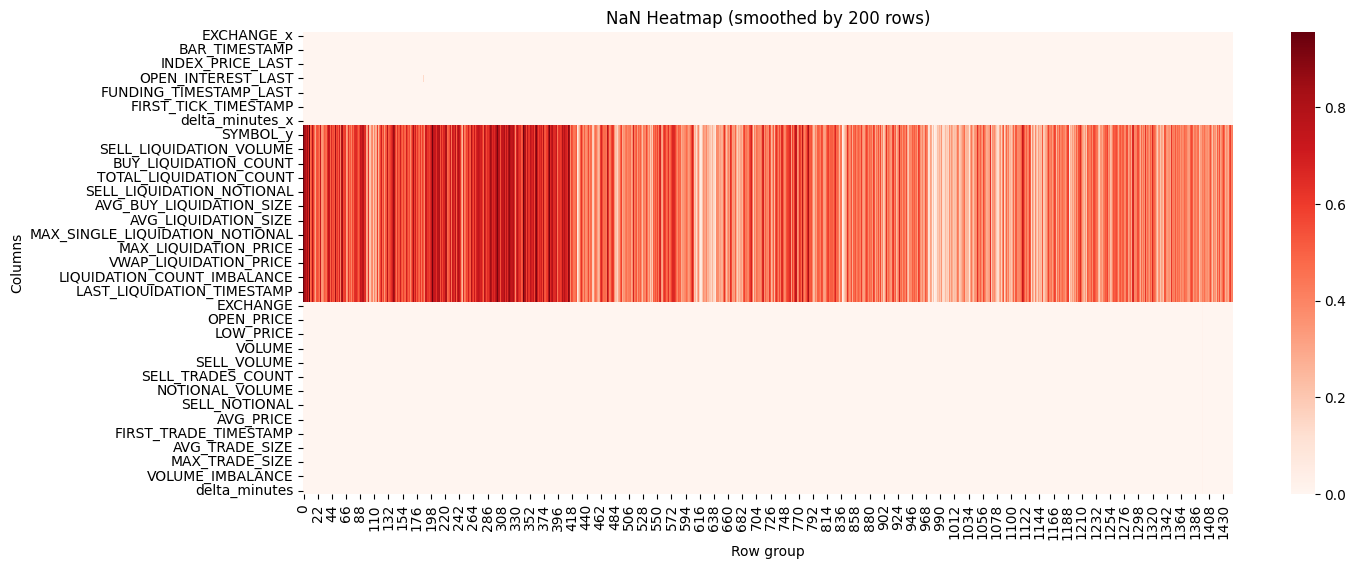

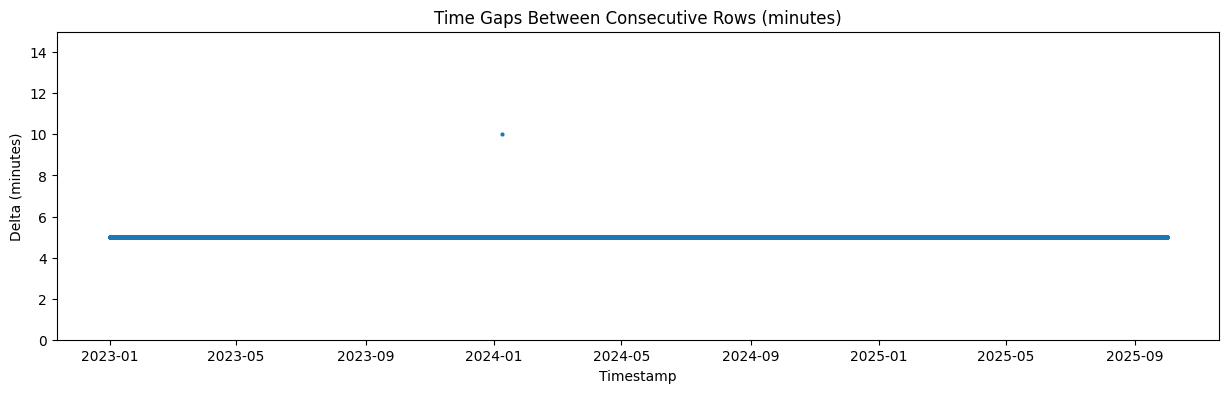

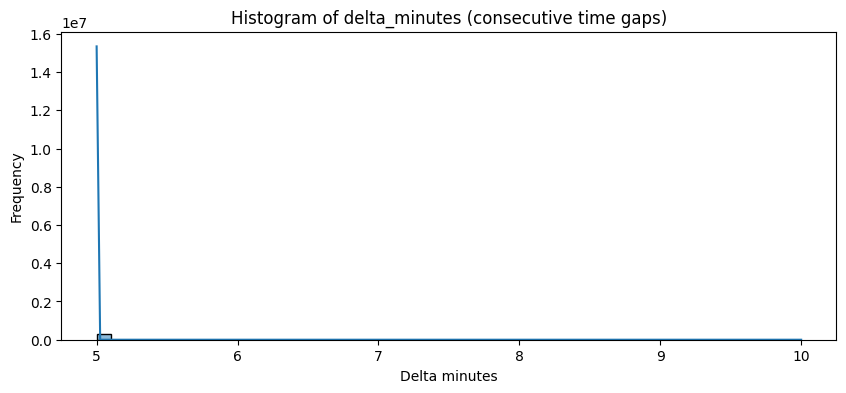

=== delta_minutes Statistics ===
count    289150.000000
mean          5.000017
std           0.009298
min           5.000000
25%           5.000000
50%           5.000000
75%           5.000000
max          10.000000
Name: delta_minutes, dtype: float64
Number of rows with delta != 5 minutes: 2


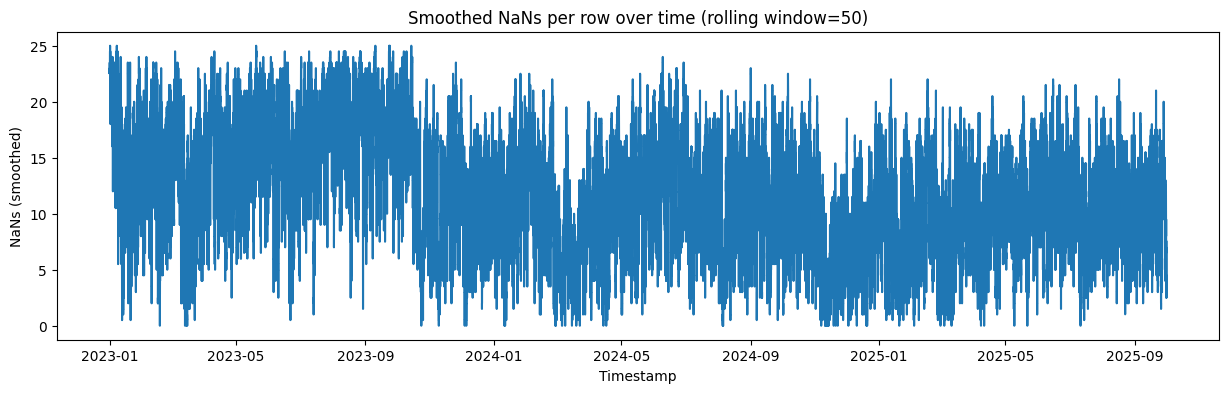

In [34]:
plot_data(df_merged)

In [37]:
out= data_check_structured(df_merged)

In [38]:
out['timestamp_summary']

{'total_rows': 289151,
 'duplicate_timestamps': 0,
 'non_5min_count': 2,
 'non_5min_percent': 0.0,
 'non_5min_max': np.float64(10.0),
 'non_5min_min': np.float64(10.0),
 'non_5min_mean': np.float64(10.0),
 'non_5min_std': np.float64(nan)}

In [39]:
out['missing_intervals_df'].head(5)

,BAR_TIMESTAMP,delta_minutes
0,2023-01-01 00:00:00,NaN
107361,2024-01-08 18:50:00,10.0


In [40]:
df_merged.iloc[107359:107363]

,EXCHANGE_x,SYMBOL_x,BAR_TIMESTAMP,MARK_PRICE_LAST,INDEX_PRICE_LAST,LAST_PRICE_LAST,OPEN_INTEREST_LAST,FUNDING_RATE_LAST,FUNDING_TIMESTAMP_LAST,TICK_COUNT,...,PRICE_STDDEV,FIRST_TRADE_TIMESTAMP,LAST_TRADE_TIMESTAMP,AVG_TRADE_SIZE,MIN_TRADE_SIZE,MAX_TRADE_SIZE,TRADE_SIZE_STDDEV,VOLUME_IMBALANCE,TRADE_COUNT_IMBALANCE,delta_minutes
107359,binance-futures,BTCUSDT,2024-01-08 18:35:00,46654.000000,46640.663617,46662.1,74389.178,0.0001,2024-01-09 00:00:00.000,453,...,194.744733,2024-01-08 18:35:00.010,2024-01-08 18:39:59.985,0.118444,0.001,163.992,0.698587,3523.714,18417.0,5.0
107360,binance-futures,BTCUSDT,2024-01-08 18:40:00,46804.063986,46797.227021,46827.9,74943.654,0.0001,2024-01-09 00:00:00.000,456,...,126.201258,2024-01-08 18:40:00.019,2024-01-08 18:44:46.587,0.114191,0.001,53.746,0.481161,502.314,6822.0,5.0
107361,binance-futures,BTCUSDT,2024-01-08 18:50:00,46727.886216,46722.445106,46730.2,74726.176,0.0001,2024-01-09 00:00:00.000,416,...,78.181812,2024-01-08 18:50:29.519,2024-01-08 18:54:59.997,0.092435,0.001,31.860,0.397619,-889.911,-7868.0,10.0
107362,binance-futures,BTCUSDT,2024-01-08 18:55:00,46973.062525,46962.872128,46977.7,74620.634,0.0001,2024-01-09 00:00:00.000,448,...,60.996664,2024-01-08 18:55:00.022,2024-01-08 18:59:59.997,0.080060,0.001,33.305,0.350016,258.909,2701.0,5.0


In [52]:
#  add one row of timestamp 2024-01-08  18:45:00 with all NaN columns 
new_row = {col: np.nan for col in df.columns}
new_row['BAR_TIMESTAMP'] = pd.Timestamp('2024-01-08 18:45:00')
new_row['EXCHANGE_x'] = 'binance-futures'
new_row['SYMBOL_x'] = 'BTCUSDT'

df_merged = pd.concat([df_merged, pd.DataFrame([new_row])], ignore_index=True).sort_values('BAR_TIMESTAMP').reset_index(drop=True)


In [53]:
out= data_check_structured(df_merged)

In [54]:
out['timestamp_summary']

{'total_rows': 289152,
 'duplicate_timestamps': 0,
 'non_5min_count': 1,
 'non_5min_percent': 0.0,
 'non_5min_max': np.float64(nan),
 'non_5min_min': np.float64(nan),
 'non_5min_mean': nan,
 'non_5min_std': np.float64(nan)}

In [55]:
out['missing_intervals_df'].head(5)

,BAR_TIMESTAMP,delta_minutes
0,2023-01-01,NaN


In [57]:
print(out['nan_analysis'].to_string())

                             column  nan_count  nan_percent  longest_consecutive_nan
0                        EXCHANGE_x          0         0.00                        0
1                          SYMBOL_x          0         0.00                        0
2                     BAR_TIMESTAMP          0         0.00                        0
3                   MARK_PRICE_LAST          1         0.00                        1
4                  INDEX_PRICE_LAST          1         0.00                        1
5                   LAST_PRICE_LAST          1         0.00                        1
6                OPEN_INTEREST_LAST         37         0.01                       26
7                 FUNDING_RATE_LAST          1         0.00                        1
8            FUNDING_TIMESTAMP_LAST          1         0.00                        1
9                        TICK_COUNT          1         0.00                        1
10             FIRST_TICK_TIMESTAMP          1         0.00      

In [64]:
# save nan analysis
out['nan_analysis'].to_csv("../sample_data/nan_summary.csv", index=True)


In [18]:
out['numeric_stats'].tail(5)

,min,max,mean,std,range
MAX_TRADE_SIZE,0.5430,903.5780,15.3187,27.7544,903.0350
TRADE_SIZE_STDDEV,0.0358,8.7249,0.2930,0.2200,8.6891
VOLUME_IMBALANCE,-26094.1050,19170.2690,-4.9863,379.6176,45264.3740
TRADE_COUNT_IMBALANCE,-103401.0000,90830.0000,-42.2107,2671.7395,194231.0000
delta_minutes,5.0000,10.0000,5.0000,0.0093,5.0000


In [58]:
del df, df2, df3
gc.collect()

14750

In [60]:
df_merged.head()

,EXCHANGE_x,SYMBOL_x,BAR_TIMESTAMP,MARK_PRICE_LAST,INDEX_PRICE_LAST,LAST_PRICE_LAST,OPEN_INTEREST_LAST,FUNDING_RATE_LAST,FUNDING_TIMESTAMP_LAST,TICK_COUNT,...,PRICE_STDDEV,FIRST_TRADE_TIMESTAMP,LAST_TRADE_TIMESTAMP,AVG_TRADE_SIZE,MIN_TRADE_SIZE,MAX_TRADE_SIZE,TRADE_SIZE_STDDEV,VOLUME_IMBALANCE,TRADE_COUNT_IMBALANCE,delta_minutes
0,binance-futures,BTCUSDT,2023-01-01 00:00:00,16529.200000,16535.114333,16529.2,105581.777,0.0001,2023-01-01 08:00:00.000,531.0,...,4.658046,2023-01-01 00:00:04.118,2023-01-01 00:04:59.783,0.207688,0.001,12.656,0.551623,-238.467,-1223.0,NaN
1,binance-futures,BTCUSDT,2023-01-01 00:05:00,16521.500000,16527.421047,16521.5,105607.666,0.0001,2023-01-01 08:00:00.000,534.0,...,4.730635,2023-01-01 00:05:00.045,2023-01-01 00:09:59.917,0.130437,0.001,8.458,0.360166,-86.071,-653.0,5.0
2,binance-futures,BTCUSDT,2023-01-01 00:10:00,16517.400000,16522.583810,16517.4,105604.357,0.0001,2023-01-01 08:00:00.000,529.0,...,1.988034,2023-01-01 00:10:00.477,2023-01-01 00:14:59.947,0.138483,0.001,3.766,0.297205,19.624,-367.0,5.0
3,binance-futures,BTCUSDT,2023-01-01 00:15:00,16530.443023,16536.537968,16530.1,105641.237,0.0001,2023-01-01 08:00:00.000,518.0,...,6.020564,2023-01-01 00:15:00.135,2023-01-01 00:19:59.341,0.194185,0.001,5.000,0.412914,68.448,452.0,5.0
4,binance-futures,BTCUSDT,2023-01-01 00:20:00,16531.800000,16536.153333,16531.8,105733.505,0.0001,2023-01-01 08:00:00.000,512.0,...,2.118028,2023-01-01 00:20:00.250,2023-01-01 00:24:59.628,0.155921,0.001,5.057,0.348629,81.538,335.0,5.0


In [61]:
df_merged.columns

Index(['EXCHANGE_x', 'SYMBOL_x', 'BAR_TIMESTAMP', 'MARK_PRICE_LAST',
       'INDEX_PRICE_LAST', 'LAST_PRICE_LAST', 'OPEN_INTEREST_LAST',
       'FUNDING_RATE_LAST', 'FUNDING_TIMESTAMP_LAST', 'TICK_COUNT',
       'FIRST_TICK_TIMESTAMP', 'LAST_TICK_TIMESTAMP', 'delta_minutes_x',
       'EXCHANGE_y', 'SYMBOL_y', 'BUY_LIQUIDATION_VOLUME',
       'SELL_LIQUIDATION_VOLUME', 'TOTAL_LIQUIDATION_VOLUME',
       'BUY_LIQUIDATION_COUNT', 'SELL_LIQUIDATION_COUNT',
       'TOTAL_LIQUIDATION_COUNT', 'BUY_LIQUIDATION_NOTIONAL',
       'SELL_LIQUIDATION_NOTIONAL', 'TOTAL_LIQUIDATION_NOTIONAL',
       'AVG_BUY_LIQUIDATION_SIZE', 'AVG_SELL_LIQUIDATION_SIZE',
       'AVG_LIQUIDATION_SIZE', 'MAX_SINGLE_LIQUIDATION_SIZE',
       'MAX_SINGLE_LIQUIDATION_NOTIONAL', 'MIN_LIQUIDATION_PRICE',
       'MAX_LIQUIDATION_PRICE', 'AVG_LIQUIDATION_PRICE',
       'VWAP_LIQUIDATION_PRICE', 'LIQUIDATION_VOLUME_IMBALANCE',
       'LIQUIDATION_COUNT_IMBALANCE', 'FIRST_LIQUIDATION_TIMESTAMP',
       'LAST_LIQUIDATION_TIMEST

# C. Data Preprocessing + NaN Handling

## Feature Engineering Pipeline: 3-Bucket Strategy

### 0. PRE-PROCESSING (The "Liquidation Fix")
*Convert raw liquidation price levels into stationary "Distance to Danger" signals before bucketing.*

**Input Columns:**
- AVG_LIQUIDATION_PRICE
- VWAP_LIQUIDATION_PRICE
- MIN_LIQUIDATION_PRICE
- MAX_LIQUIDATION_PRICE

**Action:**
1. **NaN Strategy:** `ffill()` (Forward Fill to persist last known level).
2. **Transformation:** Create new "Distance" features:
   $$X_{dist} = \ln(\text{Liq Price}) - \ln(\text{Close Price})$$
3. **Placement:** Move these new `DIST_*` features into **Bucket C**.

---

### 1. BUCKET A: PRICE & TREND (Drifting Memory)
**Behavior:** Continuous, high-memory time series.
**Goal:** Preserve trend memory while fixing stationarity.

**Columns:**
- CLOSE_PRICE, OPEN_PRICE, HIGH_PRICE, LOW_PRICE
- VWAP, AVG_PRICE
- MARK_PRICE_LAST, INDEX_PRICE_LAST, LAST_PRICE_LAST
- OPEN_INTEREST_LAST

**Pipeline:**
1. **Transform:** Natural Log ($\ln(x)$)
2. **Stationarity:** FracDiff (FFD, $d \approx 0.4$)
3. **Scaling:** Z-Score (StandardScaler)

---

### 2. BUCKET B: VOLUME & ACTIVITY (Bursty / Heavy Tails)
**Behavior:** Sparse, "spiky" data with power-law distribution (whales).
**Goal:** Compress outliers and handle sparsity.

**Columns:**
- **Flows:** VOLUME, *_VOLUME, *_NOTIONAL (Buy/Sell/Total)
- **Counts:** TICK_COUNT, *_TRADES_COUNT
- **Liquidations:** *_LIQUIDATION_VOLUME, *_LIQUIDATION_NOTIONAL, *_LIQUIDATION_COUNT
- **Sizes/Vol:** AVG_*_SIZE, MAX_*_SIZE, PRICE_STDDEV, TRADE_SIZE_STDDEV

**Pipeline:**
1. **NaN Strategy:** Fill with `0`
2. **Transform:** `np.log1p(x)` (Log of $x+1$)
3. **Scaling:** RobustScaler (Median/IQR to ignore outliers)

---

### 3. BUCKET C: RATIOS & OSCILLATORS (Bounded / Relative)
**Behavior:** Mean-reverting values that oscillate around a baseline.
**Goal:** Normalize range and clip extreme deviations.

**Columns:**
- **Market State:** FUNDING_RATE_LAST
- **Imbalances:** VOLUME_IMBALANCE, TRADE_COUNT_IMBALANCE
- **Liq Ratios:** LIQUIDATION_VOLUME_IMBALANCE, LIQUIDATION_COUNT_IMBALANCE
- **Price Spreads (New):** DIST_MIN_LIQ, DIST_MAX_LIQ, DIST_AVG_LIQ, DIST_VWAP_LIQ

**Pipeline:**
1. **NaN Strategy:** Fill `0` (Imbalances) or `ffill` (Spreads)
2. **Transform:** Winsorize (Clip extreme 1% tails)
3. **Scaling:** MinMax Scaler (-1 to 1) or Z-Score

---

### 4. METADATA (Drop)
**Action:** Set `BAR_TIMESTAMP` as Index, drop the rest.

**Columns:**
- EXCHANGE, SYMBOL
- FIRST_LIQUIDATION_TIMESTAMP, LAST_LIQUIDATION_TIMESTAMP
- FIRST_TRADE_TIMESTAMP, LAST_TRADE_TIMESTAMP
- FUNDING_TIMESTAMP_LAST

In [25]:
# ==========================================
# PHASE 0: LIQUIDATION DATA NAN HANDLING
# ==========================================

# 1. Define Column Groups
# ------------------------------------------
# Group A: Flows & Activity (Events that didn't happen = 0)
liq_flow_cols = [
    'BUY_LIQUIDATION_VOLUME', 'SELL_LIQUIDATION_VOLUME', 'TOTAL_LIQUIDATION_VOLUME',
    'BUY_LIQUIDATION_COUNT', 'SELL_LIQUIDATION_COUNT', 'TOTAL_LIQUIDATION_COUNT',
    'BUY_LIQUIDATION_NOTIONAL', 'SELL_LIQUIDATION_NOTIONAL', 'TOTAL_LIQUIDATION_NOTIONAL',
    'AVG_BUY_LIQUIDATION_SIZE', 'AVG_SELL_LIQUIDATION_SIZE', 'AVG_LIQUIDATION_SIZE',
    'MAX_SINGLE_LIQUIDATION_SIZE', 'MAX_SINGLE_LIQUIDATION_NOTIONAL',
    'LIQUIDATION_VOLUME_IMBALANCE', 'LIQUIDATION_COUNT_IMBALANCE' # Imbalances also 0 if no events
]

# Group B: Liquidation Levels (Price Zones persist until updated)
liq_price_cols = [
    'AVG_LIQUIDATION_PRICE', 'VWAP_LIQUIDATION_PRICE', 
    'MIN_LIQUIDATION_PRICE', 'MAX_LIQUIDATION_PRICE'
]
# timestamp columns not mentioned here they are being dropped

In [65]:
df_merged[['EXCHANGE_x', 'EXCHANGE_y', 'SYMBOL_x', 'SYMBOL_y']].isna().sum()   

EXCHANGE_x         0
EXCHANGE_y    135243
SYMBOL_x           0
SYMBOL_y      135243
dtype: int64

In [67]:
core_price_cols = [
    'OPEN_PRICE', 'HIGH_PRICE', 'LOW_PRICE', 'CLOSE_PRICE',       
    'VWAP', 'AVG_PRICE',                                          
    'MARK_PRICE_LAST', 'INDEX_PRICE_LAST', 'LAST_PRICE_LAST',     
    'OPEN_INTEREST_LAST',
    'FUNDING_RATE_LAST'  
]
core_vol_cols = [
    'VOLUME', 'BUY_VOLUME', 'SELL_VOLUME', 
    'NOTIONAL_VOLUME', 'BUY_NOTIONAL', 'SELL_NOTIONAL',
    'TRADES_COUNT', 'TOTAL_TRADES_COUNT', 'BUY_TRADES_COUNT', 'SELL_TRADES_COUNT',
    'TICK_COUNT',      
    'PRICE_STDDEV', 'TRADE_SIZE_STDDEV',
    'AVG_TRADE_SIZE', 'MIN_TRADE_SIZE', 'MAX_TRADE_SIZE',
    'VOLUME_IMBALANCE', 'TRADE_COUNT_IMBALANCE'
]
liq_flow_cols = [
    'BUY_LIQUIDATION_VOLUME', 'SELL_LIQUIDATION_VOLUME', 'TOTAL_LIQUIDATION_VOLUME',
    'BUY_LIQUIDATION_COUNT', 'SELL_LIQUIDATION_COUNT', 'TOTAL_LIQUIDATION_COUNT',
    'BUY_LIQUIDATION_NOTIONAL', 'SELL_LIQUIDATION_NOTIONAL', 'TOTAL_LIQUIDATION_NOTIONAL',
    'AVG_BUY_LIQUIDATION_SIZE', 'AVG_SELL_LIQUIDATION_SIZE', 'AVG_LIQUIDATION_SIZE',
    'MAX_SINGLE_LIQUIDATION_SIZE', 'MAX_SINGLE_LIQUIDATION_NOTIONAL',
    'LIQUIDATION_VOLUME_IMBALANCE', 'LIQUIDATION_COUNT_IMBALANCE'
]
liq_price_cols = [
    'AVG_LIQUIDATION_PRICE', 'VWAP_LIQUIDATION_PRICE', 
    'MIN_LIQUIDATION_PRICE', 'MAX_LIQUIDATION_PRICE'
]

In [68]:
len(liq_price_cols), len(liq_flow_cols), len(core_price_cols), len(core_vol_cols)

(4, 16, 11, 18)

In [79]:
arr = liq_price_cols + liq_flow_cols + core_price_cols + core_vol_cols


In [80]:
len(df_merged.columns.tolist())

58

In [81]:
feat = [a for a in df_merged if ("SYMBOL" not in a) and ("EXCHANGE" not in a) and ("TIMESTAMP" not in a)]

In [82]:
arr = liq_price_cols + liq_flow_cols + core_price_cols + core_vol_cols
feat = [a for a in df_merged.columns.to_list() if ("SYMBOL" not in a) and ("EXCHANGE" not in a) and ("TIMESTAMP" not in a) and ("delta" not in a)]
not_considered = [a for a in feat if a not in arr]
not_considered

[]

In [83]:
to_be_considered = [a for a  in df_merged.columns.to_list() if a not in arr ]
to_be_considered

['EXCHANGE',
 'SYMBOL',
 'BAR_TIMESTAMP',
 'FUNDING_TIMESTAMP_LAST',
 'FIRST_TICK_TIMESTAMP',
 'LAST_TICK_TIMESTAMP',
 'FIRST_LIQUIDATION_TIMESTAMP',
 'LAST_LIQUIDATION_TIMESTAMP',
 'FIRST_TRADE_TIMESTAMP',
 'LAST_TRADE_TIMESTAMP']

In [ ]:
# ==============================================================================
# PHASE 0.1: MERGE ARTIFACT CLEANUP
# ==============================================================================
# 1. Drop duplicate/high-NaN columns
cols_to_drop = [
    'EXCHANGE', 'SYMBOL',               
    'EXCHANGE_y', 'SYMBOL_y',           
    'EXCHANGE.1', 'SYMBOL.1',
    'delta_minutes_y', 'delta_minutes_x', 'delta_minutes'     
]
existing_drop = [c for c in cols_to_drop if c in df_merged.columns]
df_merged.drop(columns=existing_drop, inplace=True)

# 2. Rename valid columns
rename_map = {  
    'EXCHANGE_x': 'EXCHANGE',
    'SYMBOL_x': 'SYMBOL'
}
df_merged.rename(columns=rename_map, inplace=True)


In [84]:

# ==============================================================================
# PHASE 0.2: CORE MARKET DATA CLEANUP
# ==============================================================================

# A. Prices & States -> Forward Fill
existing_price_cols = [c for c in core_price_cols if c in df_merged.columns]
df_merged[existing_price_cols] = df_merged[existing_price_cols].ffill()

# B. Volumes, Counts & Statistics -> Fill with 0
existing_vol_cols = [c for c in core_vol_cols if c in df_merged.columns]
df_merged[existing_vol_cols] = df_merged[existing_vol_cols].fillna(0)



In [85]:
# ==============================================================================
# PHASE 0.3: LIQUIDATION DATA CLEANUP
# ==============================================================================

# Group A: Liquidation Flows (Events) -> Fill with 0
existing_liq_flow = [c for c in liq_flow_cols if c in df_merged.columns]
df_merged[existing_liq_flow] = df_merged[existing_liq_flow].fillna(0)

# Group B: Liquidation Levels (Prices) -> Forward Fill
existing_liq_price = [c for c in liq_price_cols if c in df_merged.columns]
df_merged[existing_liq_price] = df_merged[existing_liq_price].ffill()


In [86]:
# ==============================================================================
# PHASE 0.4: FINAL SAFETY CHECK
# ==============================================================================
# Drop rows where ffill failed at the start
df_merged.dropna(subset=existing_price_cols, inplace=True)

# Verification
print("Final NaN Check (Should only show timestamps):")
print(df_merged.isna().sum()[df_merged.isna().sum() > 0])
print(f"Final Shape: {df_merged.shape}")

Final NaN Check (Should only show timestamps):
FUNDING_TIMESTAMP_LAST              1
FIRST_TICK_TIMESTAMP                1
LAST_TICK_TIMESTAMP                 1
MIN_LIQUIDATION_PRICE               1
MAX_LIQUIDATION_PRICE               1
AVG_LIQUIDATION_PRICE               1
VWAP_LIQUIDATION_PRICE              1
FIRST_LIQUIDATION_TIMESTAMP    135243
LAST_LIQUIDATION_TIMESTAMP     135243
FIRST_TRADE_TIMESTAMP               9
LAST_TRADE_TIMESTAMP                9
dtype: int64
Final Shape: (289152, 58)


In [101]:
alrproc = [a for a in df_merged.columns.to_list() if ("SYMBOL" not in a) and ("EXCHANGE" not in a) and ("TIMESTAMP" not in a)]    
toproc = [a for a in df_merged.columns.tolist() if a not in alrproc]

In [102]:
alrproc

['MARK_PRICE_LAST',
 'INDEX_PRICE_LAST',
 'LAST_PRICE_LAST',
 'OPEN_INTEREST_LAST',
 'FUNDING_RATE_LAST',
 'TICK_COUNT',
 'BUY_LIQUIDATION_VOLUME',
 'SELL_LIQUIDATION_VOLUME',
 'TOTAL_LIQUIDATION_VOLUME',
 'BUY_LIQUIDATION_COUNT',
 'SELL_LIQUIDATION_COUNT',
 'TOTAL_LIQUIDATION_COUNT',
 'BUY_LIQUIDATION_NOTIONAL',
 'SELL_LIQUIDATION_NOTIONAL',
 'TOTAL_LIQUIDATION_NOTIONAL',
 'AVG_BUY_LIQUIDATION_SIZE',
 'AVG_SELL_LIQUIDATION_SIZE',
 'AVG_LIQUIDATION_SIZE',
 'MAX_SINGLE_LIQUIDATION_SIZE',
 'MAX_SINGLE_LIQUIDATION_NOTIONAL',
 'MIN_LIQUIDATION_PRICE',
 'MAX_LIQUIDATION_PRICE',
 'AVG_LIQUIDATION_PRICE',
 'VWAP_LIQUIDATION_PRICE',
 'LIQUIDATION_VOLUME_IMBALANCE',
 'LIQUIDATION_COUNT_IMBALANCE',
 'OPEN_PRICE',
 'HIGH_PRICE',
 'LOW_PRICE',
 'CLOSE_PRICE',
 'VOLUME',
 'BUY_VOLUME',
 'SELL_VOLUME',
 'BUY_TRADES_COUNT',
 'SELL_TRADES_COUNT',
 'TOTAL_TRADES_COUNT',
 'NOTIONAL_VOLUME',
 'BUY_NOTIONAL',
 'SELL_NOTIONAL',
 'VWAP',
 'AVG_PRICE',
 'PRICE_STDDEV',
 'AVG_TRADE_SIZE',
 'MIN_TRADE_SIZE',
 

In [103]:
toproc

['EXCHANGE',
 'SYMBOL',
 'BAR_TIMESTAMP',
 'FUNDING_TIMESTAMP_LAST',
 'FIRST_TICK_TIMESTAMP',
 'LAST_TICK_TIMESTAMP',
 'FIRST_LIQUIDATION_TIMESTAMP',
 'LAST_LIQUIDATION_TIMESTAMP',
 'FIRST_TRADE_TIMESTAMP',
 'LAST_TRADE_TIMESTAMP']

## Harvesting Timestamps - cannot use raw

1. Liq_Duration = First_Liq_Timestamp - Last_Liq_Timestamp
2. Liq_Latency = Last_Liq_Timestamp - Bar_Timestamp
3. Trade Span = Last_Trade_Timestamp - First_Trade_Timestamp
4. Tick Span = Last_Tick_Timestamp - First_Tick_Timestamp
5. Seconds_since_funding = Bar_Timestamp - Funding_Timestamp_Last 

In [106]:
# ==========================================
# PHASE 0.5: TIMESTAMP ENGINEERING & FINAL POLISH
# ==========================================

# 0. Convert to DateTime Objects
for col in df_merged.columns :
    if "TIMESTAMP" in col:
        df_merged[col] = pd.to_datetime(df_merged[col], errors='coerce')


# 1. Harvest "Velocity" & "Span" Features
# ------------------------------------------------
# We extract signals from ALL timestamp columns before dropping them.

# A. Liquidation Velocity
# LIQ_DURATION: Flash crash (0s) vs Slow bleed (high values).
df_merged['LIQ_DURATION'] = (
    df_merged['LAST_LIQUIDATION_TIMESTAMP'] - df_merged['FIRST_LIQUIDATION_TIMESTAMP']
).dt.total_seconds().fillna(0)

# LIQ_LATENCY: Did it happen at the start or end of the bar? (Momentum signal)
df_merged['LIQ_LATENCY'] = (
    df_merged['LAST_LIQUIDATION_TIMESTAMP'] - df_merged['BAR_TIMESTAMP']
).dt.total_seconds().fillna(0)

# B. Trade Liquidity Span
# TRADE_SPAN: Did trading occur continuously (300s) or in a single burst (<1s)?
df_merged['TRADE_SPAN'] = (
    df_merged['LAST_TRADE_TIMESTAMP'] - df_merged['FIRST_TRADE_TIMESTAMP']
).dt.total_seconds().fillna(0)

# C. Tick Microstructure Span
# TICK_SPAN: Granular measure of order book activity duration.
df_merged['TICK_SPAN'] = (
    df_merged['LAST_TICK_TIMESTAMP'] - df_merged['FIRST_TICK_TIMESTAMP']
).dt.total_seconds().fillna(0)

# D. Funding Seasonality
# SECONDS_SINCE_FUNDING: Proximity to the 8-hour funding payout/squeeze.
df_merged['SECONDS_SINCE_FUNDING'] = (
    df_merged['BAR_TIMESTAMP'] - df_merged['FUNDING_TIMESTAMP_LAST']
).dt.total_seconds().fillna(0)

In [107]:
# 2. Drop Raw Metadata Columns
# ------------------------------------------------
ts_cols_to_drop = [
    'FIRST_LIQUIDATION_TIMESTAMP', 'LAST_LIQUIDATION_TIMESTAMP',
    'FIRST_TRADE_TIMESTAMP', 'LAST_TRADE_TIMESTAMP',
    'FIRST_TICK_TIMESTAMP', 'LAST_TICK_TIMESTAMP',
    'FUNDING_TIMESTAMP_LAST' 
]
existing_ts_drop = [c for c in ts_cols_to_drop if c in df_merged.columns]
df_merged.drop(columns=existing_ts_drop, inplace=True)



In [108]:

# 3. Final Edge Case Cleanup (The "1 NaN" Row)
# ------------------------------------------------
liq_price_cols = [
    'AVG_LIQUIDATION_PRICE', 'VWAP_LIQUIDATION_PRICE', 
    'MIN_LIQUIDATION_PRICE', 'MAX_LIQUIDATION_PRICE'
]
# Only check subset if columns exist
existing_liq_checks = [c for c in liq_price_cols if c in df_merged.columns]
if existing_liq_checks:
    df_merged.dropna(subset=existing_liq_checks, inplace=True)


In [109]:
# 4. Final Verification
# ------------------------------------------------
print("--- FINAL DATASET STATUS ---")
print(f"Total Rows: {len(df_merged)}")
print(f"Columns: {len(df_merged.columns)}")
print("Remaining NaNs (Must be 0):")
print(df_merged.isna().sum().sum())

# Preview
print("\nNew Features Sample:")
print(df_merged[['LIQ_DURATION', 'TRADE_SPAN']].head())

--- FINAL DATASET STATUS ---
Total Rows: 289151
Columns: 56
Remaining NaNs (Must be 0):
0

New Features Sample:
   LIQ_DURATION  TRADE_SPAN
1           0.0     299.872
2           0.0     299.470
3           0.0     299.206
4           0.0     299.378
5           0.0     299.600


In [110]:
df_merged[['LIQ_DURATION', 'TRADE_SPAN', 'LIQ_LATENCY', 'TICK_SPAN', 'SECONDS_SINCE_FUNDING']].head()

,LIQ_DURATION,TRADE_SPAN,LIQ_LATENCY,TICK_SPAN,SECONDS_SINCE_FUNDING
1,0.0,299.872,231.925,298.540,-28500.0
2,0.0,299.470,0.000,299.065,-28200.0
3,0.0,299.206,142.478,298.994,-27900.0
4,0.0,299.378,0.000,299.617,-27600.0
5,0.0,299.600,0.000,299.589,-27300.0


In [111]:
df_merged.columns.tolist()

['EXCHANGE',
 'SYMBOL',
 'BAR_TIMESTAMP',
 'MARK_PRICE_LAST',
 'INDEX_PRICE_LAST',
 'LAST_PRICE_LAST',
 'OPEN_INTEREST_LAST',
 'FUNDING_RATE_LAST',
 'TICK_COUNT',
 'BUY_LIQUIDATION_VOLUME',
 'SELL_LIQUIDATION_VOLUME',
 'TOTAL_LIQUIDATION_VOLUME',
 'BUY_LIQUIDATION_COUNT',
 'SELL_LIQUIDATION_COUNT',
 'TOTAL_LIQUIDATION_COUNT',
 'BUY_LIQUIDATION_NOTIONAL',
 'SELL_LIQUIDATION_NOTIONAL',
 'TOTAL_LIQUIDATION_NOTIONAL',
 'AVG_BUY_LIQUIDATION_SIZE',
 'AVG_SELL_LIQUIDATION_SIZE',
 'AVG_LIQUIDATION_SIZE',
 'MAX_SINGLE_LIQUIDATION_SIZE',
 'MAX_SINGLE_LIQUIDATION_NOTIONAL',
 'MIN_LIQUIDATION_PRICE',
 'MAX_LIQUIDATION_PRICE',
 'AVG_LIQUIDATION_PRICE',
 'VWAP_LIQUIDATION_PRICE',
 'LIQUIDATION_VOLUME_IMBALANCE',
 'LIQUIDATION_COUNT_IMBALANCE',
 'OPEN_PRICE',
 'HIGH_PRICE',
 'LOW_PRICE',
 'CLOSE_PRICE',
 'VOLUME',
 'BUY_VOLUME',
 'SELL_VOLUME',
 'BUY_TRADES_COUNT',
 'SELL_TRADES_COUNT',
 'TOTAL_TRADES_COUNT',
 'NOTIONAL_VOLUME',
 'BUY_NOTIONAL',
 'SELL_NOTIONAL',
 'VWAP',
 'AVG_PRICE',
 'PRICE_STDDEV

In [112]:
len(df_merged.columns)

56

In [113]:
df_merged.to_csv("../sample_data/nan_processed_data.csv", index=False)

In [117]:
del  df_merged

In [118]:
gc.collect()

31952

# FINAL DATA CHECK

In [123]:
df = pd.read_csv("../sample_data/btc_5min_nan_processed_data.csv", parse_dates=["BAR_TIMESTAMP"]).sort_values("BAR_TIMESTAMP").reset_index(drop=True)

In [124]:
gc.collect()

3597

In [126]:
out = data_check_structured(df)

In [127]:
out['missing_intervals_df'].head(10)

,BAR_TIMESTAMP,delta_minutes
0,2023-01-01 00:05:00,NaN


In [130]:
out['nan_analysis'].head(100)

,column,nan_count,nan_percent,longest_consecutive_nan
0,EXCHANGE,0,0.0,0
1,SYMBOL,0,0.0,0
2,BAR_TIMESTAMP,0,0.0,0
3,MARK_PRICE_LAST,0,0.0,0
4,INDEX_PRICE_LAST,0,0.0,0
5,LAST_PRICE_LAST,0,0.0,0
6,OPEN_INTEREST_LAST,0,0.0,0
7,FUNDING_RATE_LAST,0,0.0,0
8,TICK_COUNT,0,0.0,0
9,BUY_LIQUIDATION_VOLUME,0,0.0,0


In [132]:
out['numeric_stats'].head(5)

,min,max,mean,std,range
MARK_PRICE_LAST,16500.0000,124214.4933,62267.1939,31176.8580,107714.4933
INDEX_PRICE_LAST,16509.6239,124179.1052,62279.8311,31186.9473,107669.4813
LAST_PRICE_LAST,16499.8000,124249.9000,62266.1046,31176.2021,107750.1000
OPEN_INTEREST_LAST,5540.7540,128427.9980,87914.9332,11888.5912,122887.2440
FUNDING_RATE_LAST,-0.0002,0.0012,0.0001,0.0001,0.0014


In [133]:
out['timestamp_summary']

{'total_rows': 289151,
 'duplicate_timestamps': 0,
 'non_5min_count': 1,
 'non_5min_percent': 0.0,
 'non_5min_max': np.float64(nan),
 'non_5min_min': np.float64(nan),
 'non_5min_mean': nan,
 'non_5min_std': np.float64(nan)}

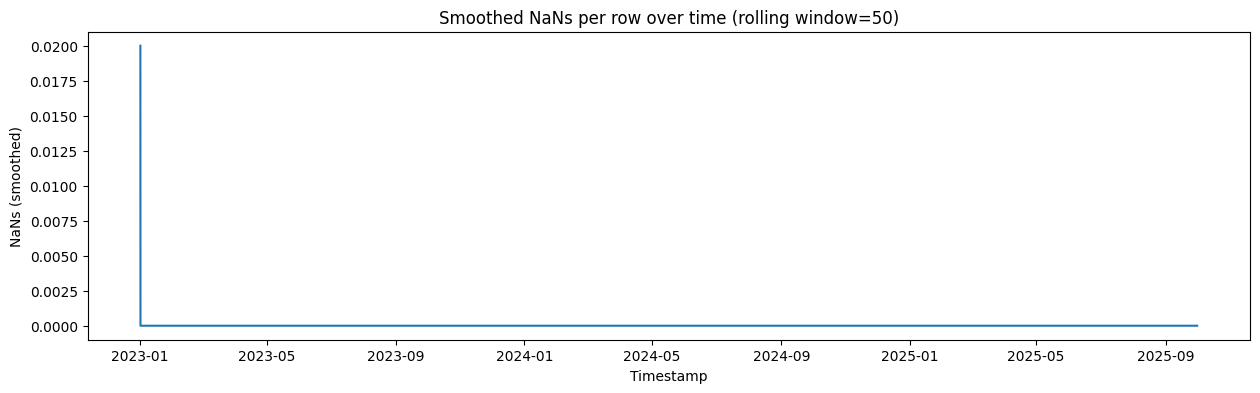

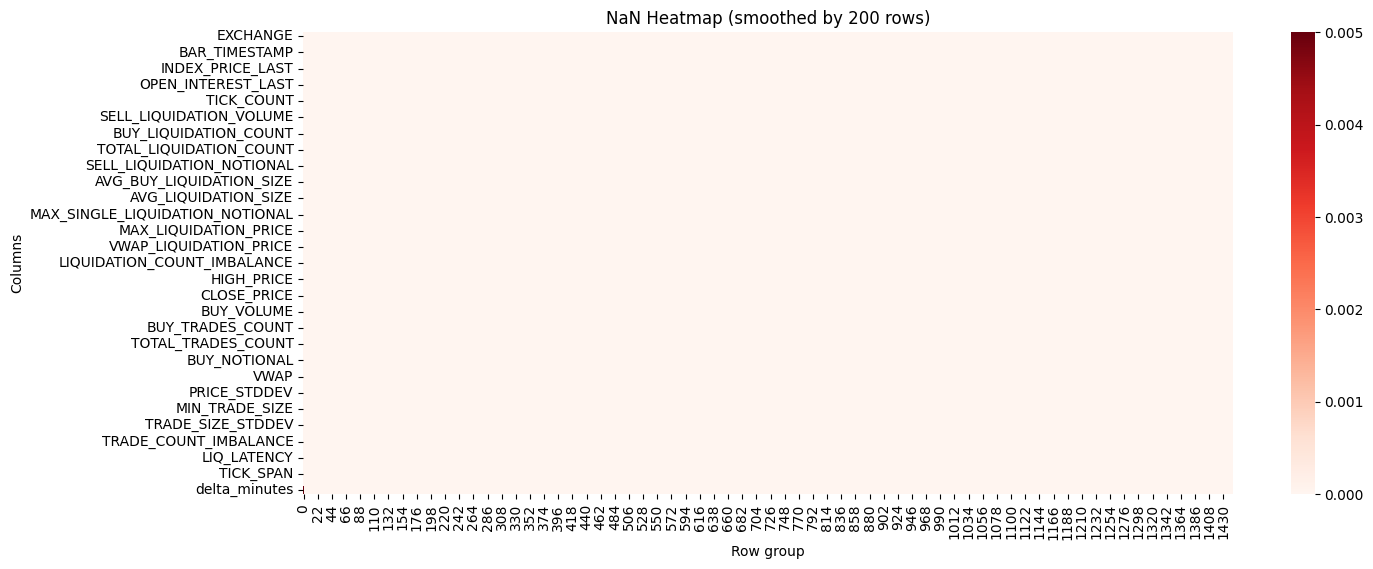

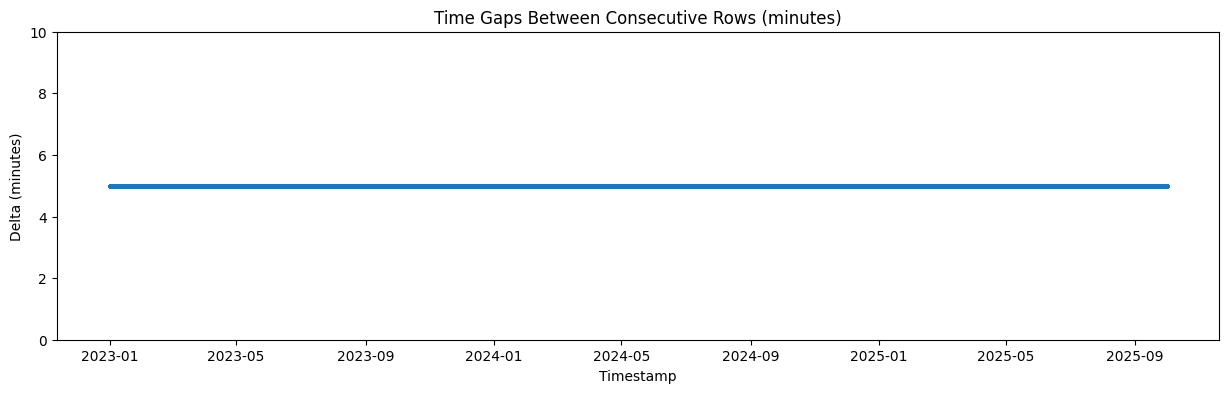

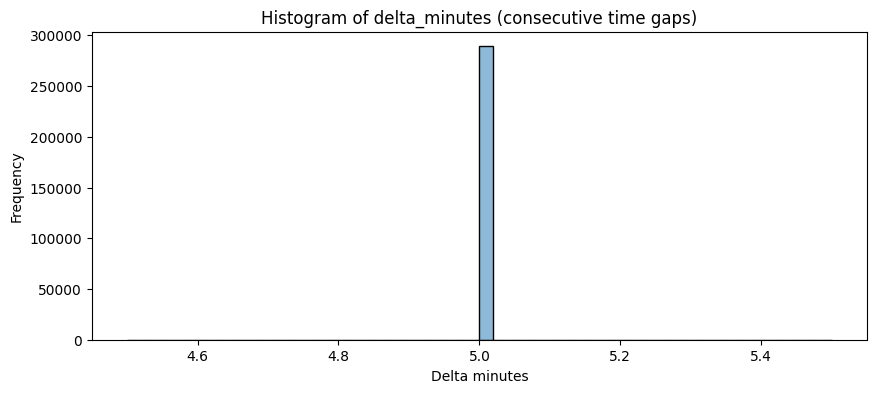

=== delta_minutes Statistics ===
count    289150.0
mean          5.0
std           0.0
min           5.0
25%           5.0
50%           5.0
75%           5.0
max           5.0
Name: delta_minutes, dtype: float64
Number of rows with delta != 5 minutes: 1


In [134]:
plot_data(df)